<h2> Importing Packages </h2>
Numpy for scientific computation <br>
Pandas for accessing the csv file with data <br>
sklearn.model_selection for selecting train, dev, test sets in a re producable way.

In [1330]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math

<h2> Preparing Train, Dev and Test Sets </h2>

In [1331]:
 ## Load Data
df = pd.read_csv('Data/financial_data2.csv')
df = df.dropna()

In [1332]:
## Splitting into X and Y
X = df.drop('Price', axis=1)
Y = df['Price']

In [1333]:
## First Split 60% for train and 40% for not train
X_train, X_not_train, Y_train, Y_not_train = train_test_split(X, Y, test_size=0.4, random_state=42)
## Second Split Allocating the 40% Remaining data equally between Test and Dev sets (20% each)
X_dev, X_test, Y_dev, Y_test = train_test_split(X_not_train, Y_not_train, test_size=0.5, random_state=42)

In [1334]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_dev = scaler.transform(X_dev)
X_test = scaler.transform(X_test)

<h2> Helper Function Development <h2>

In [1335]:
def sigmoid(z): ## Sigmoid Function
    return 1/(1+np.exp(-z))

In [1336]:
def relu(x): ## ReLU (Rectified Linear Unit) Function
    return np.maximum(0, x)

In [1337]:
def initialize_parameters(n_x, n_h1, n_h2, n_y): ## Inititalize the "W" Parameters to avoid the resulting linear function if all the same originally
    np.random.seed(1)
    W1 = np.random.randn(n_h1, n_x) * 0.01
    b1 = np.zeros((n_h1, 1))
    W2 = np.random.randn(n_h2, n_h1) * 0.01
    b2 = np.zeros((n_h2, 1))
    W3 = np.random.randn(n_y, n_h2) * 0.01
    b3 = np.zeros((n_y, 1))

    parameters = {"W1": W1, "b1": b1,
                  "W2": W2, "b2": b2,
                  "W3": W3, "b3": b3}

    return parameters

In [1338]:
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]

    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = Z3  # No activation for the last layer

    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)

    return A3, cache

In [1339]:
def compute_cost(A3, Y): # Mean Squared Error
    m = Y.shape[1]
    cost = (1 / (2 * m)) * np.sum(np.square(A3 - Y)) 
    return cost

In [1340]:
def backward_propagation(X, Y, cache):
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache

    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)

    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)

    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}

    return gradients

In [1341]:
def update_parameters(parameters, grads, learning_rate):
    parameters["W1"] = parameters["W1"] - learning_rate * grads["dW1"]
    parameters["b1"] = parameters["b1"] - learning_rate * grads["db1"]
    parameters["W2"] = parameters["W2"] - learning_rate * grads["dW2"]
    parameters["b2"] = parameters["b2"] - learning_rate * grads["db2"]
    parameters["W3"] = parameters["W3"] - learning_rate * grads["dW3"]
    parameters["b3"] = parameters["b3"] - learning_rate * grads["db3"]

    return parameters

In [1342]:
def initialize_adam(parameters) :
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(1, L + 1):
        v["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        v["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])
        s["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        s["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])
    
    return v, s

In [1343]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    L = len(parameters) // 2
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(1, L + 1):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads['dW' + str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads['db' + str(l)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l)] = v["db" + str(l)] / (1 - np.power(beta1, t))

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * np.power(grads['dW' + str(l)], 2)
        s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * np.power(grads['db' + str(l)], 2)

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l)] = s["db" + str(l)] / (1 - np.power(beta2, t))

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)]) + epsilon)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * v_corrected["db" + str(l)] / (np.sqrt(s_corrected["db" + str(l)]) + epsilon)

    return parameters, v, s, v_corrected, s_corrected

In [1344]:
def random_mini_batches(X, Y, mini_batch_size=2048, seed=0):
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []

    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))

    num_complete_minibatches = math.floor(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k+1) * mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size :]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size :]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

In [1345]:
def update_lr(learning_rate0, epoch_num, decay_rate):
    learning_rate = (1/(1+(decay_rate*epoch_num)))*learning_rate0
    return learning_rate

In [1346]:
def schedule_lr_decay(learning_rate0, epoch_num, decay_rate, time_interval=1000):
    learning_rate = (1/(1+decay_rate*np.floor(epoch_num/time_interval)))*learning_rate0
    return learning_rate

In [1347]:
def model1(X, Y, learning_rate = 0.00001, num_iterations = 350001): ## Without Adam and Batch Gradient Descent
    grads = {}
    costs = [] 
    m = X.shape[1] 
    layers_dims = [X.shape[0], 20, 7, 1]

    parameters = initialize_parameters(layers_dims[0], layers_dims[1], layers_dims[2], layers_dims[3])

    for i in range(0, num_iterations):
        A3, cache = forward_propagation(X, parameters)
        cost = compute_cost(A3, Y)
        grads = backward_propagation(X, Y, cache)
        parameters = update_parameters(parameters, grads, learning_rate)

        if i % 100 == 0:
            if i % 1000 == 0:
                print("Cost after iteration Model1 {}: {}".format(i, cost))
            costs.append(cost)

    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per thousands)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()
    
    return parameters

In [1348]:
def model2(X, Y, learning_rate = 0.00001, num_iterations = 360001, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8): ## With Adam Single Batch Gradient Decent
    grads = {}
    costs = [] 
    m = X.shape[1] 
    layers_dims = [X.shape[0], 20, 7, 1]

    parameters = initialize_parameters(layers_dims[0], layers_dims[1], layers_dims[2], layers_dims[3])
    
    # Initialize v and s for Adam optimizer
    v, s = initialize_adam(parameters)
    t = 0

    for i in range(num_iterations):
        # Forward propagation
        A3, cache = forward_propagation(X, parameters)

        # Compute cost
        cost = compute_cost(A3, Y)

        # Backward propagation
        grads = backward_propagation(X, Y, cache)

        # Update parameters using Adam optimization
        t = t + 1 # Increment the timestep 't'
        parameters, v, s, v_corrected, s_corrected = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)

        # Print the cost every 1000 iterations
        if i % 100 == 0:
            if i % 1000 == 0:
                print("Cost after iteration Model2 {}: {}".format(i, cost))
            costs.append(cost)
            
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per thousands)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()  
    
    return parameters

In [1349]:
def model3(X, Y, learning_rate = 0.0000001, num_iterations = 180001, mini_batch_size = 2048, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8): ## Mini Batch With Adam Opimizer
    grads = {}
    costs = [] 
    m = X.shape[1] 
    layers_dims = [X.shape[0], 20, 7, 1]

    parameters = initialize_parameters(layers_dims[0], layers_dims[1], layers_dims[2], layers_dims[3])
    # Initialize v and s for Adam optimizer
    v, s = initialize_adam(parameters)
    t = 0
    for i in range(num_iterations):
        # Create mini-batches
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed = i)

        for minibatch in minibatches:
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            A3, cache = forward_propagation(minibatch_X, parameters)

            # Compute cost
            cost = compute_cost(A3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, cache)

            # Update parameters using Adam optimization
            t = t + 1 # Increment the timestep 't'
            parameters, v, s, v_corrected, s_corrected = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)

        # Print the cost every 1000 iterations
        if i % 100 == 0:
            if i % 1000 == 0:
                print("Cost after iteration Model3 {}: {}".format(i, cost))
            costs.append(cost)
    
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per thousands)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show() 
    
    return parameters


In [1350]:
def model4(X, Y, learning_rate0 = 0.000001, num_iterations = 180001, mini_batch_size = 2048, decay_rate = 0.001, time_interval=1000, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8): ## Mini Batch With Adam Opimizer and Learning Rate Decay
    grads = {}
    costs = [] 
    m = X.shape[1] 
    layers_dims = [X.shape[0], 20, 7, 1]

    parameters = initialize_parameters(layers_dims[0], layers_dims[1], layers_dims[2], layers_dims[3])
    # Initialize v and s for Adam optimizer
    v, s = initialize_adam(parameters)
    t = 0
    for i in range(num_iterations):
        # Create mini-batches
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed = i)

        learning_rate = update_lr(learning_rate0, i, decay_rate) # update learning rate using exponential decay
        
        for minibatch in minibatches:
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            A3, cache = forward_propagation(minibatch_X, parameters)

            # Compute cost
            cost = compute_cost(A3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, cache)

            # Update parameters using Adam optimization
            t = t + 1 # Increment the timestep 't'
            parameters, v, s, v_corrected, s_corrected = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)

        # Update the learning rate every time_interval epochs
        if i % time_interval == 0:
            learning_rate = schedule_lr_decay(learning_rate0, i, decay_rate, time_interval)

        # Print the cost every 1000 iterations
        if i % 100 == 0:
            if i % 1000 == 0:
                print("Cost after iteration Model4 {}: {}".format(i, cost))
            costs.append(cost)
            
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per thousands)')
    plt.title("Learning rate = " + str(learning_rate0))
    plt.show()   
    
    return parameters


In [1351]:
# X_train = X_train.values.T
X_train = X_train.T
Y_train = Y_train.values.reshape(1, -1)

# Run the model
# parameters1 = model1(X_train, Y_train)
# parameters2 = model2(X_train, Y_train)
# parameters3 = model3(X_train, Y_train)
# parameters4 = model4(X_train, Y_train)

Cost after iteration Model1 0: 14982.102892863948
Cost after iteration Model1 1000: 14921.946967830294
Cost after iteration Model1 2000: 14862.94917206602
Cost after iteration Model1 3000: 14804.962986180763
Cost after iteration Model1 4000: 14747.426694343496
Cost after iteration Model1 5000: 14687.960997495522
Cost after iteration Model1 6000: 14616.065336666361
Cost after iteration Model1 7000: 14447.89419210902
Cost after iteration Model1 8000: 505.48752963764355
Cost after iteration Model1 9000: 300.0855904732903
Cost after iteration Model1 10000: 284.16139140204865
Cost after iteration Model1 11000: 280.3139895724089
Cost after iteration Model1 12000: 279.34004502733296
Cost after iteration Model1 13000: 279.0056699860744
Cost after iteration Model1 14000: 278.82709062191566
Cost after iteration Model1 15000: 278.69953886021244
Cost after iteration Model1 16000: 278.5909898042847
Cost after iteration Model1 17000: 278.49309348502135
Cost after iteration Model1 18000: 278.40508290

Cost after iteration Model1 153000: 262.83770553022913
Cost after iteration Model1 154000: 262.71004708061815
Cost after iteration Model1 155000: 262.58674419772933
Cost after iteration Model1 156000: 262.468432842351
Cost after iteration Model1 157000: 262.3550845878745
Cost after iteration Model1 158000: 262.24424964235953
Cost after iteration Model1 159000: 262.13203140156935
Cost after iteration Model1 160000: 262.02715565376815
Cost after iteration Model1 161000: 261.9237768396486
Cost after iteration Model1 162000: 261.8240070298313
Cost after iteration Model1 163000: 261.7284460535663
Cost after iteration Model1 164000: 261.6357582829887
Cost after iteration Model1 165000: 261.54646360846846
Cost after iteration Model1 166000: 261.4607022117549
Cost after iteration Model1 167000: 261.3736188337923
Cost after iteration Model1 168000: 261.27812866577773
Cost after iteration Model1 169000: 261.1937235998836
Cost after iteration Model1 170000: 261.1157195288448
Cost after iteration 

Cost after iteration Model1 304000: 245.46110369824234
Cost after iteration Model1 305000: 245.36124227377795
Cost after iteration Model1 306000: 245.26185997863706
Cost after iteration Model1 307000: 245.1622833011432
Cost after iteration Model1 308000: 245.06143528743496
Cost after iteration Model1 309000: 244.95980742231336
Cost after iteration Model1 310000: 244.85603171251583
Cost after iteration Model1 311000: 244.75086648019425
Cost after iteration Model1 312000: 244.64515008245314
Cost after iteration Model1 313000: 244.53842493274473
Cost after iteration Model1 314000: 244.43166882346893
Cost after iteration Model1 315000: 244.324016200565
Cost after iteration Model1 316000: 244.21471383938666
Cost after iteration Model1 317000: 244.1034957687433
Cost after iteration Model1 318000: 243.99176139334028
Cost after iteration Model1 319000: 243.87997759210762
Cost after iteration Model1 320000: 243.76747814268714
Cost after iteration Model1 321000: 243.6544636341191
Cost after iter

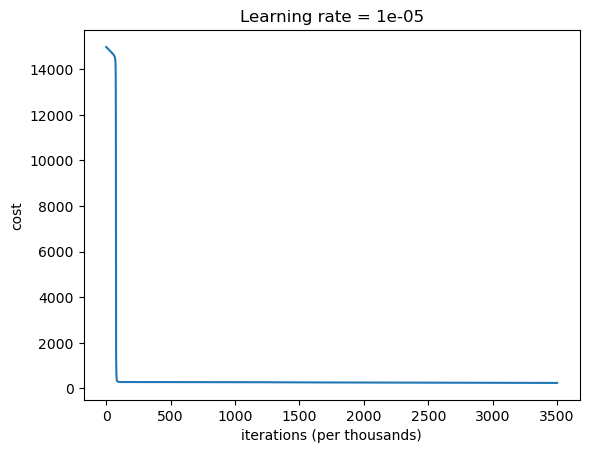

In [1352]:
parameters1 = model1(X_train, Y_train)

In [ ]:
parameters2 = model2(X_train, Y_train)

Cost after iteration Model2 0: 14982.102892863948
Cost after iteration Model2 1000: 14981.043877216754
Cost after iteration Model2 2000: 14978.809400028244
Cost after iteration Model2 3000: 14974.830082049568
Cost after iteration Model2 4000: 14968.905809952896
Cost after iteration Model2 5000: 14960.84814350846
Cost after iteration Model2 6000: 14950.463147419214
Cost after iteration Model2 7000: 14937.549966169814
Cost after iteration Model2 8000: 14921.903691998084
Cost after iteration Model2 9000: 14903.318707996948
Cost after iteration Model2 10000: 14881.591105511354
Cost after iteration Model2 11000: 14856.519815471358
Cost after iteration Model2 12000: 14827.90741020427
Cost after iteration Model2 13000: 14795.560586192118
Cost after iteration Model2 14000: 14759.290491848227
Cost after iteration Model2 15000: 14718.913043687195
Cost after iteration Model2 16000: 14674.249190293785
Cost after iteration Model2 17000: 14625.125188145195
Cost after iteration Model2 18000: 14571.37

Cost after iteration Model2 153000: 373.3607383052834
Cost after iteration Model2 154000: 364.18401486565995
Cost after iteration Model2 155000: 355.6954454970476
Cost after iteration Model2 156000: 347.90264190698366
Cost after iteration Model2 157000: 340.7897904663283
Cost after iteration Model2 158000: 334.34342385034495
Cost after iteration Model2 159000: 328.5632821098683
Cost after iteration Model2 160000: 323.43187087830313
Cost after iteration Model2 161000: 318.91978568044595
Cost after iteration Model2 162000: 314.9821254178104
Cost after iteration Model2 163000: 311.5469262369022
Cost after iteration Model2 164000: 308.50126279898535
Cost after iteration Model2 165000: 305.70113740762736
Cost after iteration Model2 166000: 303.0206768170669
Cost after iteration Model2 167000: 300.46102183201833
Cost after iteration Model2 168000: 298.0570498466997
Cost after iteration Model2 169000: 295.8139126794884
Cost after iteration Model2 170000: 293.71438292370914
Cost after iteratio

Cost after iteration Model2 304000: 257.57348635042763
Cost after iteration Model2 305000: 257.5055102269905
Cost after iteration Model2 306000: 257.4376827105764
Cost after iteration Model2 307000: 257.36234710905933
Cost after iteration Model2 308000: 257.28320639548053
Cost after iteration Model2 309000: 257.20835590214824
Cost after iteration Model2 310000: 257.1340661332576
Cost after iteration Model2 311000: 257.0660432090574
Cost after iteration Model2 312000: 256.99904833596685
Cost after iteration Model2 313000: 256.92900708369234
Cost after iteration Model2 314000: 256.8586443410353
Cost after iteration Model2 315000: 256.77975887994063
Cost after iteration Model2 316000: 256.7060344274493
Cost after iteration Model2 317000: 256.6312807423052


In [ ]:
parameters3 = model3(X_train, Y_train)

In [ ]:
parameters4 = model4(X_train, Y_train)

In [ ]:
def predict(X, parameters):
    A3, cache = forward_propagation(X, parameters)
    
    return A3

In [ ]:
# X_dev = X_dev.values.T
Y_dev = Y_dev.values.reshape(1, -1)
X_dev = X_dev.T

In [ ]:
predictions_dev1 = predict(X_dev, parameters1)
predictions_dev2 = predict(X_dev, parameters2)
predictions_dev3 = predict(X_dev, parameters3)
predictions_dev4 = predict(X_dev, parameters4)

In [ ]:
dev_cost1 = compute_cost(predictions_dev1, Y_dev)
print("Cost on dev set Model1: {}".format(dev_cost1))

dev_cost2 = compute_cost(predictions_dev2, Y_dev)
print("Cost on dev set Model2: {}".format(dev_cost2))

dev_cost3 = compute_cost(predictions_dev3, Y_dev)
print("Cost on dev set Model3: {}".format(dev_cost3))

dev_cost4 = compute_cost(predictions_dev4, Y_dev)
print("Cost on dev set Model4: {}".format(dev_cost4))

In [ ]:
# for i in range(len(predictions_dev[0])):
#     print("Predicted: " + str(predictions_dev[0][i]) + " Actual: " + str(Y_dev.T[i]))

In [ ]:
# X_test = X_test.values.T
# Y_test = Y_test.values.reshape(1, -1)

In [ ]:
# predictions_test = predict(X_test, parameters)

In [ ]:
# test_cost = compute_cost(predictions_test, Y_test)
# print("Cost on test set: {}".format(test_cost))

In [ ]:
# for i in range(len(predictions_test[0])):
#     print("Predicted: " + str(predictions_test[0][i]) + " Actual: " + str(Y_test.T[i]))